# NLP Keyword Extraction

### TF-IDF (Term Frequency - Inverse Document Frequency) Algorithm

* Corpus $D$: collection of text instances
* Document $d$: text instance
* Term $t$: token in text
* $N$: corpus size
* Term Frequency:
$$ \text{tf} = \text{tf}(t, d) $$
* Inverse Document Frequency:
$$ \text{idf}(t, D) = \text{log} \frac{N + 1}{\vert d \in D: t \in d \vert + 1} $$
* TF-IDF:
$$ \text{tfidf}(t, d, D) = \text{tf}(t, d) * \text{idf}(t, D)$$

### TF IDF Text Mining Process

1. Load in corpus of documents $D$ - *(document_id, text)*
    * Load in document collection as a dictionary with unique document ids for keys and the corresponding text blobs for values
    
    
2. Clean text $d$ - *(document_id, text, cleaned_text)*
    * Cleaning depends on the type of documents
    * A simple filter might only keep: alphanumeric, whitespace and basic puntuation
    
    
3. Produce n-grams up to a limit - *(document_id, gram)*
    * Apply udfs which utilize the `nltk` package
    * Filter out certain grams containing stop words


4. Produce document and corpus frequencies
    * Compute gram count per document
    * Compute distinct document count per gram


5. Compute and sort by tf-idf scores - *(document_id, gram, tf_idf_score)*
    * Apply the above tf-idf function as a udf

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pyspark.sql.functions import col, udf, count, countDistinct, explode
from pyspark.sql.types import ArrayType, BooleanType, FloatType, StringType, StructType, StructField
import random
import re
import requests
from wordcloud import WordCloud

In [2]:
EMPTY = ''
SPACE = ' '
MAX_GRAMS = 4

STOP_WORDS = set(stopwords.words('english'))
TWITTER_COMMON_TOKENS = ['http', 'https', 'like', 'video']
STOP_WORDS = STOP_WORDS.union(TWITTER_COMMON_TOKENS)

## Load Sample Twitter Troll Data

In [3]:
URL = 'https://raw.githubusercontent.com/fivethirtyeight/russian-troll-tweets/master/IRAhandle_tweets_1.csv'

response = requests.get(URL)
tweet_data = response.text.split('\r\n')
tweet_data = [row.split(',') for row in tweet_data]
del tweet_data[-1]
print(len(tweet_data))

243892


In [4]:
SAMPLE_SIZE = 10000
random.seed(42)
header = tweet_data[0]
tweet_data = [d for d in tweet_data if d[4] == 'English']
tweet_data = [header] + random.sample(tweet_data, SAMPLE_SIZE)

In [5]:
list(zip(tweet_data[0], tweet_data[1]))

[('external_author_id', '2570250275'),
 ('author', 'AIDEN7757'),
 ('content', '#HowToMakeAManGay force him to be a gay'),
 ('region', 'United States'),
 ('language', 'English'),
 ('publish_date', '5/30/2016 14:47'),
 ('harvested_date', '5/30/2016 14:47'),
 ('following', '1346'),
 ('followers', '553'),
 ('updates', '1018'),
 ('post_type', 'RETWEET'),
 ('account_type', 'Hashtager'),
 ('retweet', '1'),
 ('account_category', 'HashtagGamer'),
 ('new_june_2018', '0'),
 ('alt_external_id', '2570250275'),
 ('tweet_id', '737294277416484866'),
 ('article_url', 'http://twitter.com/Aiden7757/statuses/737294277416484866'),
 ('tco1_step1', ''),
 ('tco2_step1', ''),
 ('tco3_step1', '')]

In [6]:
DOCUMENT_LABEL_LABEL = 'document_label'
TEXT_LABEL = 'text'
DOCUMENT_LABEL_INDEX = 1
TEXT_INDEX = 2

schema = StructType([
    StructField(name=DOCUMENT_LABEL_LABEL, dataType=StringType(), nullable=False),
    StructField(name=TEXT_LABEL, dataType=StringType(), nullable=False)
])
input_df = spark.createDataFrame([[row[DOCUMENT_LABEL_INDEX], row[TEXT_INDEX]] for row in tweet_data[1:]], schema)
print(input_df.count())
input_df.show()

10000
+--------------+--------------------+
|document_label|                text|
+--------------+--------------------+
|     AIDEN7757|#HowToMakeAManGay...|
|  ABIGAILSSILK|Build the wall. N...|
| AMELIEBALDWIN|#IslamKills RT @B...|
| AMELIEBALDWIN|I would love to s...|
| AMELIEBALDWIN|'@emeralds3 @Elen...|
|    ALDRICH420|#NoCyberCensorshi...|
|     AFEELIUTR|#ade Dan Rather i...|
|    ARM_2_ALAN|Which GOP preside...|
|     ADRGREERR|China detains act...|
|ANITALOVEHEART|Donald Trump told...|
|    ABMERRLINS|McMaster and Susa...|
|    ABIISSROSB|JihadiInfo this i...|
|   ADRIENNE_GG|My favorite dog b...|
|     AMBERRPAR|RT redsteeze: Las...|
| AMELIEBALDWIN|Liberal Propagand...|
|    ARM_2_ALAN|NY Time’s David B...|
|  ABIGAILSSILK|"50°C Shades of G...|
|ATLANTA_ONLINE|Authorities inves...|
|  AMANDAVGREEN|https://t.co/aZtV...|
|    ARM_2_ALAN|Obama administrat...|
+--------------+--------------------+
only showing top 20 rows



## Clean

In [7]:
TWITTER_EXCLUSION_REGEX = [
    re.compile(r'https\:\/\/.*\s')
]
WS_REGEX = re.compile(r'\s')
CLEAN_REGEX = re.compile(r'[^a-z0-9\.!\?;:]')
EXTRA_SPACE_REGEX = re.compile(r'\040{1,}')

def clean_text(text):
    clean_text = text.lower()
    for regex in TWITTER_EXCLUSION_REGEX:
        clean_text = regex.sub(SPACE, clean_text)
    clean_text = WS_REGEX.sub(SPACE, clean_text)
    clean_text = CLEAN_REGEX.sub(SPACE, clean_text)
    clean_regex = EXTRA_SPACE_REGEX.sub(SPACE, clean_text)
    return clean_text

In [8]:
CLEAN_TEXT_LABEL = 'clean_text'

clean_wiki_df = input_df \
    .withColumn(CLEAN_TEXT_LABEL, udf(clean_text, StringType())(col(TEXT_LABEL))) \
    .select(DOCUMENT_LABEL_LABEL, TEXT_LABEL, CLEAN_TEXT_LABEL)
print(clean_wiki_df.count())
clean_wiki_df.show(5)

10000
+--------------+--------------------+--------------------+
|document_label|                text|          clean_text|
+--------------+--------------------+--------------------+
|     AIDEN7757|#HowToMakeAManGay...| howtomakeamangay...|
|  ABIGAILSSILK|Build the wall. N...|build the wall. n...|
| AMELIEBALDWIN|#IslamKills RT @B...| islamkills rt  b...|
| AMELIEBALDWIN|I would love to s...|i would love to s...|
| AMELIEBALDWIN|'@emeralds3 @Elen...|  emeralds3  elen...|
+--------------+--------------------+--------------------+
only showing top 5 rows



## Grams

In [9]:
SENTENCE_REGEX = re.compile(r'[\n\t\.\?!;:]')
MIN_GRAM_LENGTH = 4

def build_sentences(text):
    return [s for s in [sentence.strip() for sentence in SENTENCE_REGEX.split(text)] if s != EMPTY]

def build_grams_from_tokens(tokens, N):
    grams = []
    for n in range(1, N + 1):
        grams += [SPACE.join(grams) for grams in ngrams(tokens, n)]
    return grams 

def build_grams_from_text(text, N=MAX_GRAMS):
    sentences = build_sentences(text)
    sentence_tokens = [word_tokenize(s) for s in sentences]
    return [build_grams_from_tokens(tokens, N) for tokens in sentence_tokens]

def filter_gram(gram):
    return len([g for g in gram.split(SPACE) if g in STOP_WORDS]) == 0 \
        and len(gram) >= MIN_GRAM_LENGTH 

In [10]:
GRAMS_ARR_LABEL = 'grams_arr'
GRAMS_LABEL = 'grams'
GRAM_LABEL = 'gram'

gram_df = clean_wiki_df \
    .withColumn(GRAMS_ARR_LABEL, udf(build_grams_from_text, ArrayType(ArrayType(StringType(), containsNull=False), containsNull=False))(col(CLEAN_TEXT_LABEL))) \
    .withColumn(GRAMS_LABEL, explode(GRAMS_ARR_LABEL)) \
    .withColumn(GRAM_LABEL, explode(GRAMS_LABEL)) \
    .select(DOCUMENT_LABEL_LABEL, GRAM_LABEL) \
    .filter(udf(filter_gram, BooleanType())(GRAM_LABEL))
print(gram_df.count())
gram_df.show(5)

151149
+--------------+--------------------+
|document_label|                gram|
+--------------+--------------------+
|     AIDEN7757|    howtomakeamangay|
|     AIDEN7757|               force|
|     AIDEN7757|howtomakeamangay ...|
|  ABIGAILSSILK|               build|
|  ABIGAILSSILK|                wall|
+--------------+--------------------+
only showing top 5 rows



## Frequencies

In [11]:
DOCUMENT_GRAM_FREQUENCY_LABEL = 'gram_freq'

document_gram_freq_df = gram_df \
    .groupBy(GRAM_LABEL) \
    .agg(count(DOCUMENT_LABEL_LABEL).alias(DOCUMENT_GRAM_FREQUENCY_LABEL)) \
    .select(GRAM_LABEL, DOCUMENT_GRAM_FREQUENCY_LABEL)
print(document_gram_freq_df.count())
document_gram_freq_df.show(5)

88930
+--------------------+---------+
|                gram|gram_freq|
+--------------------+---------+
|        bilked panda|        1|
|scheme bilked pan...|        1|
| ig report washtimes|        1|
|               still|       93|
|          league2734|        1|
+--------------------+---------+
only showing top 5 rows



In [12]:
CORPUS_GRAM_FREQUENCY_LABEL = 'document_freq'

corpus_gram_freq_df = gram_df \
    .groupBy(GRAM_LABEL) \
    .agg(countDistinct(DOCUMENT_LABEL_LABEL).alias(CORPUS_GRAM_FREQUENCY_LABEL)) \
    .select(GRAM_LABEL, CORPUS_GRAM_FREQUENCY_LABEL)
print(corpus_gram_freq_df.count())
corpus_gram_freq_df.show(5)

88930
+--------------------+-------------+
|                gram|document_freq|
+--------------------+-------------+
|dhecei unarosabia...|            1|
|         driver hurt|            1|
|         semperficop|            1|
|             marxism|            3|
|appsame preetbharara|            1|
+--------------------+-------------+
only showing top 5 rows



## TF-IDF

In [13]:
corpus_size = input_df.count()

def tf_idf(tf, df, N=corpus_size):
    return tf * math.log( (N+1) / (df+1) )

In [14]:
TF_IDF_SCORE_LABEL = 'tf_idf_score'

tf_idf_df = document_gram_freq_df \
    .join(corpus_gram_freq_df, GRAM_LABEL) \
    .withColumn(TF_IDF_SCORE_LABEL, udf(tf_idf, FloatType())(col(DOCUMENT_GRAM_FREQUENCY_LABEL), col(CORPUS_GRAM_FREQUENCY_LABEL))) \
    .sort(TF_IDF_SCORE_LABEL, ascending=False) \
    .select(GRAM_LABEL, TF_IDF_SCORE_LABEL)
print(tf_idf_df.count())
tf_idf_df.show(20)

88930
+---------------+------------+
|           gram|tf_idf_score|
+---------------+------------+
|          trump|    5366.592|
|         enlist|   2242.2957|
|       breaking|   1560.4492|
|         people|   1467.3159|
|          obama|     1372.29|
|        hillary|   1286.0991|
|         police|    1282.217|
|           news|     1178.06|
|        america|   1110.5618|
|          white|    1027.893|
|realdonaldtrump|   1010.4456|
|           army|   987.81903|
|           time|    916.6262|
|        clinton|   910.02313|
|          black|   891.62335|
|           look|    887.6476|
|   patriot army|    851.7293|
|          potus|   844.63226|
|      president|    836.2123|
|charlottesville|    815.3912|
+---------------+------------+
only showing top 20 rows



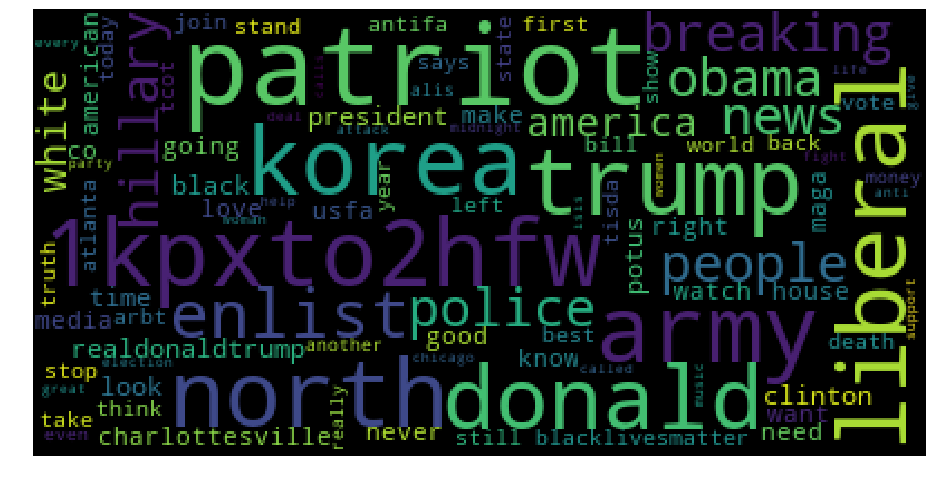

In [15]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9)

top_grams = [row.gram for row in tf_idf_df.limit(100).collect()]
wordcloud = WordCloud(
    background_color='black',
    max_font_size=50, 
    random_state=42
).generate(SPACE.join(top_grams))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()